In [1]:
from transformer_model import Transformer
import torch as t
import numpy as np
from models import SAE
import lovely_tensors as lt
from models import SAE
from losses import SAE_Loss

from IPython import get_ipython
ipython = get_ipython()
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")


lt.monkey_patch()

lr=1e-3 #@param
weight_decay = 0.00001 #@param
p=113 #@param
d_model = 128 #@param

num_epochs = 300 #@param
# Stop training when test loss is <stopping_thresh
num_layers = 3
d_vocab = p+2
n_ctx = 5
d_mlp = 4*d_model
num_heads = 4
assert d_model % num_heads == 0
d_head = d_model//num_heads
act_type = 'ReLU' #@param ['ReLU', 'GeLU']
# batch_size = 512
use_ln = False
random_answers = np.random.randint(low=0, high=p, size=(p, p))


model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln).to('cuda')
model.load_state_dict(t.load('transformer.pth'))


/tmp/ipykernel_1761288/4229106113.py:11: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_1761288/4229106113.py:12: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


<All keys matched successfully>

In [2]:
dataset = []

for a in range(p):
    for b in range(p):
        for x in range(2):
            for y in range(2):
                dataset.append((a,b,x,y,113))

dataset = t.tensor(dataset).to('cuda')

print(f'Memory Allocated: {t.cuda.memory_allocated()} bytes')


cache = {}
model.cache_all(cache)

print(f'Memory Allocated: {t.cuda.memory_allocated()} bytes')

_ = model(dataset)

print(f'Memory Allocated: {t.cuda.memory_allocated()} bytes')

resid_post_activations = [cache[f'blocks.{i}.hook_resid_post'][:, -1] for i in range(len(model.blocks))]

print(resid_post_activations[0].shape)

Memory Allocated: 4532224 bytes
Memory Allocated: 4532224 bytes
Memory Allocated: 8232384000 bytes
torch.Size([51076, 128])


In [3]:
import matplotlib.pyplot as plt

SAE_config = {
    'num_features': d_model * 4,
}

# autoencoder
sae = SAE(
    input_size = d_model,
    n_dict_components = d_model * 4
).to('cuda')

# combination of L1 and mse loss
sae_loss = SAE_Loss(
    l1_weight=1e-1,
)

sae_optimizer = t.optim.Adam(
    sae.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)

losses = []
sparsity = []
dead_neurons_per_epoch = []



dataloader = t.utils.data.DataLoader(
    resid_post_activations[0],
    batch_size=512,
    shuffle=True,
)

model.remove_all_hooks()

for epoch in range(500):

    latent_dim = sae.n_dict_components
    activation_counts = t.zeros(latent_dim, dtype=t.long).cuda()

    for i, batch_activations in enumerate(dataloader):
        sae_optimizer.zero_grad()
        x_hat, z = sae(batch_activations)
        loss = sae_loss(
            feature_values=z,
            target_activations=batch_activations,
            reconstructed_activations=x_hat
        )

        loss.backward()

        sae_optimizer.step()

        losses.append(loss.item())
        # sparsity is the number of zero activations in the latent space
        # get sparsity by finding the average number of zero in the z batch along dim 1
        sparsity.append((z == 0).float().mean().item())
        activation_counts += (z > 0).sum(dim=0).long()

    # Count dead neurons (those that have zero activations throughout the epoch)
    dead_neurons = (activation_counts == 0).sum().item()
    dead_neurons_ratio = dead_neurons / latent_dim
    dead_neurons_per_epoch.append(dead_neurons_ratio)



t.save(sae.state_dict(), 'sae.pth')

# mark point with dot
plt.plot(losses)
# labels
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()


plt.plot(sparsity)
plt.xlabel('Batch')
plt.ylabel('Sparsity')
plt.show()

plt.plot(dead_neurons_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Dead Neurons')
plt.show()




NameError: name 'resid_post_activations' is not defined

In [2]:
# load sae
sae = SAE(
    input_size = d_model,
    n_dict_components = d_model * 4
).to('cuda')

dataset = []
for a in range(p):
    for b in range(p):
        for x in range(2):
            for y in range(2):
                dataset.append((a,b,x,y,113))

dataset = t.tensor(dataset).to('cuda')

sae.load_state_dict(t.load('sae.pth'))


def hook_fn_sae(activations, name='replace_activations_with_reconstruction'):
    x_hat, z = sae(activations)
    return x_hat


# model.remove_all_hooks()
model.remove_all_hooks()
model.blocks[0].hook_resid_post.add_hook(hook_fn_sae)

correct_answers = (dataset[:, 0] + dataset[:, 1]) % 113 + t.bitwise_xor(dataset[:, 2], dataset[:, 3])


output_logits = model(dataset)[:, -1]

predicted_answers = output_logits.argmax(dim=-1)

correct = (predicted_answers == correct_answers).float().mean().item()
print(f'Accuracy: {correct}')

model.remove_all_hooks()

output_logits = model(dataset)[:, -1]

predicted_answers = output_logits.argmax(dim=-1)

correct = (predicted_answers == correct_answers).float().mean().item()

print(f'Accuracy: {correct}')




Accuracy: 0.3168807327747345
Accuracy: 0.9878416657447815


In [3]:
sae = SAE(
    input_size = d_model,
    n_dict_components = d_model * 4
).to('cuda')

sae.load_state_dict(t.load('sae.pth'))

data_set = []
for a in range(p):
    for b in range(p):
        for x in range(2):
            for y in range(2):
                data_set.append((a,b,x,y,113))

data_set = t.tensor(data_set).to('cuda')

_, z = sae(resid_post_activations[0])

xor_bits = t.bitwise_xor(data_set[:, 2], data_set[:, 3])






In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Assuming z is your representation matrix of size [batch_num, rep_dim]
# and y is your binary label vector of size [batch_num]
batch_num, rep_dim = z.shape

# Initialize an array to store the correlation coefficients
correlation_coefficients = np.zeros(rep_dim)

# Calculate Pearson correlation for each component
for i in range(rep_dim):
    correlation_coefficients[i], _ = pearsonr(z[:, i].detach().cpu().numpy(), xor_bits.cpu().numpy())

# correlation_coefficients now contains the Pearson correlation coefficient for each component
# plot the correlation coefficients bar graph
plt.bar(range(rep_dim), correlation_coefficients)
plt.xlabel('Component')
plt.ylabel('Pearson correlation')
plt.show()

# nan to zero then get argmax
correlation_coefficients[np.isnan(correlation_coefficients)] = 0
most_correlated_component = correlation_coefficients.argmax()

print(f'Most correlated component: {most_correlated_component}')


# top 5 most correlated components
most_correlated_components = correlation_coefficients.argsort()[-5:][::-1]


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

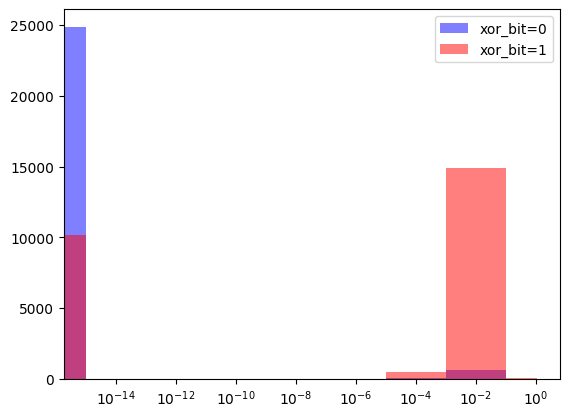

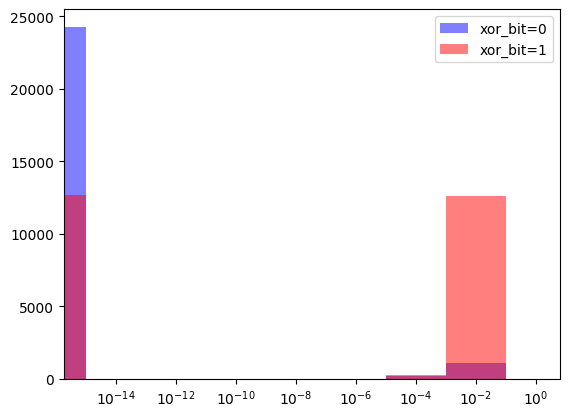

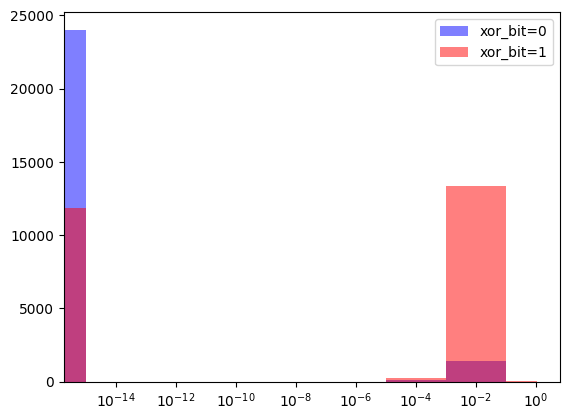

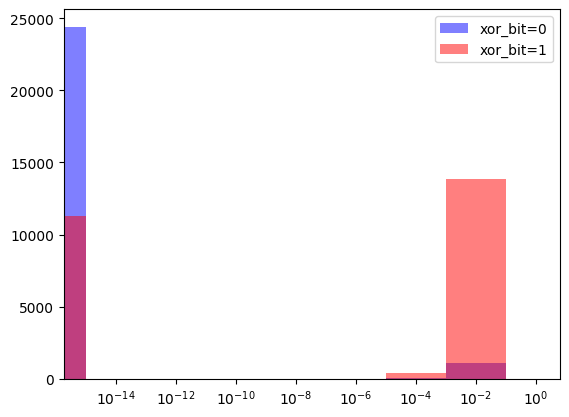

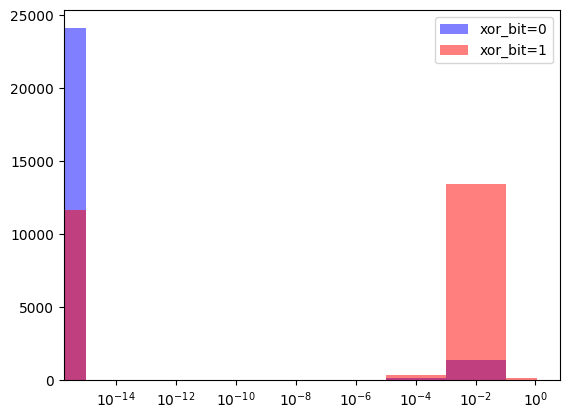

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
# z = z.detach().cpu().numpy()
# xor_bits = xor_bits.cpu().numpy()

for i in most_correlated_components:
    z_xor = z[:, i]

    # Values with xor_bit 0 and 1
    z_xor_0 = z_xor[xor_bits == 0]
    z_xor_1 = z_xor[xor_bits == 1]

    # Define bins: one for zero, one for greater than zero
    bins = [0, 1e-15, 1e-10, 1e-5, 1e-3, 1e-1, np.max(z_xor) + 1]

    # Plot histograms
    plt.hist(z_xor_0, bins=bins, color='blue', alpha=0.5, label='xor_bit=0')
    plt.hist(z_xor_1, bins=bins, color='red', alpha=0.5, label='xor_bit=1')
    plt.xscale('log')
    plt.legend()
    plt.show()


In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from idtxl.multivariate_pid import MultivariatePID
from idtxl.data import Data



# Example data: binary variables X1, X2 and continuous variable Y
X1 = np.random.randint(0, 2, 1000)
X2 = np.random.randint(0, 2, 1000)
Y = np.random.randn(1000)  # continuous variable

# Discretize the continuous target variable Y
kbin = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
Y_discretized = kbin.fit_transform(Y.reshape(-1, 1)).flatten()

# Combine the variables into a single dataset
data = np.vstack([X1, X2, Y_discretized]).T
data = pd.DataFrame(data, columns=['X1', 'X2', 'Y'])

# Convert data to IDTxl Data object
data_idtxl = Data(data.values, dim_order='ps')

# Define PID settings
settings = {
    'pid_estimator': 'BROJA'  # Using the BROJA method for PID
}

# Initialize the PID object
pid = MultivariatePID()

# Run PID analysis
pid_results = pid.analyse_single_target(settings=settings, data=data_idtxl, target=2, sources=[0, 1])

# Extract synergy
synergy = pid_results['SI'][0, 1]

print("Synergistic information:", synergy)


Adding data with properties: 1000 processes, 3 samples, 1 replications
overwriting existing data


RuntimeError: Estimator I_G not found.